<a href="https://colab.research.google.com/github/HarshaEmani/MLCourseProject/blob/main/Calgary_Experiments_4_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/Colab\ Notebooks
%ls

/content/drive/MyDrive/Colab Notebooks
bearspaw_solar_weather_combined_cat.csv            Calgary_Experiments_4_Regression.ipynb
bearspaw_weather_solar_api_combined_2017_2024.csv  Solar_Colab.ipynb
best_model_day_ahead.keras                         Untitled0.ipynb
best_model.keras


In [4]:
%autosave 60

Autosaving every 60 seconds


In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from keras.regularizers import l1, l2, l1_l2
from sklearn.ensemble import GradientBoostingRegressor
import os
import tensorflow
import pickle
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, LSTM, Dropout, Input, InputLayer, Conv1D, Flatten, GRU, RepeatVector, MaxPooling1D, TimeDistributed, Conv2D, MaxPooling2D, Bidirectional, BatchNormalization
# from keras.preprocessing import timeseries_dataset_from_array
from sklearn.metrics import precision_recall_curve, mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, mean_pinball_loss, confusion_matrix
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError, F1Score
from keras.optimizers import Adam, RMSprop, SGD
from keras.activations import swish
from keras.regularizers import L1, L2
# from statsmodels.graphics.tsaplots import plot_acf
import datetime
# from xgboost import XGBClassifier, plot_importance
# from catboost import CatBoostRegressor
import math
from keras import backend as K
import random
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve
# from catboost import CatBoostClassifier
# from tsfresh import extract_features
# from tsfresh.feature_extraction.settings import MinimalFCParameters
# from tsfresh import select_features
# from tsfresh.utilities.dataframe_functions import impute
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
# from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import pandas as pd
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
np.set_printoptions(suppress=True)
import plotly.express as px
from IPython.display import HTML
from sklearn.svm import LinearSVR
pd.set_option('display.float_format', lambda x: '%.3f' % x)

tensorflow.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:

file_path = './bearspaw_weather_solar_api_combined_2017_2024.csv'
data = pd.read_csv(file_path, index_col=0)

# Convert the datetime_gmt column to datetime format
data.index = pd.to_datetime(data.index)
# data = data.set_index(data['datetime_gmt'])
data = data.dropna()
data_11th = data.loc['2024-12-10':]
data = data.loc[:'2024-12-10']

data

kWh  temperature  humidity  rain  snowfall  \
2017-12-21 07:00:00  0.000         -9.8      64.0   0.0       0.0   
2017-12-21 08:00:00  0.000         -8.8      63.0   0.0       0.0   
2017-12-21 09:00:00  0.004         -6.1      59.0   0.0       0.0   
2017-12-21 10:00:00  0.433         -4.8      61.0   0.0       0.0   
2017-12-21 11:00:00  0.854         -4.5      69.0   0.0       0.0   
...                    ...          ...       ...   ...       ...   
2024-12-10 16:00:00  1.890         -4.9      84.0   0.0       0.0   
2024-12-10 17:00:00  0.000         -6.7      88.0   0.0       0.0   
2024-12-10 18:00:00  0.000         -4.8      91.0   0.0       0.0   
2024-12-10 19:00:00  0.000         -4.8      94.0   0.0       0.0   
2024-12-10 20:00:00  0.000         -5.3      96.0   0.0       0.0   

                     weather_code_daily  cloud_cover  is_day  \
2017-12-21 07:00:00                 2.0         51.0       0   
2017-12-21 08:00:00                 3.0         86.0       0   
2017-12-21 09:00:00                 3.0         90.0       1   
2017-12-21 10:00:00                 3.0         96.0       1   
2017-12-21 11:00:00                 3.0        100.0       1   
...                                 ...          ...     ...   
2024-12-10 16:00:00                 3.0         84.0       1   
2024-12-10 17:00:00                 3.0        100.0       0   
2024-12-10 18:00:00                 3.0        100.0       0   
2024-12-10 19:00:00                 3.0        100.0       0   
2024-12-10 20:00:00                 3.0        100.0       0   

                     sunshine_duration    GHI    DHI    DNI  
2017-12-21 07:00:00               0.00    0.0    0.0    0.0  
2017-12-21 08:00:00               0.00    0.0    0.0    0.0  
2017-12-21 09:00:00               0.00    7.2    7.2    0.0  
2017-12-21 10:00:00             826.16   81.1   63.6  133.5  
2017-12-21 11:00:00            2315.17  137.9  107.9  164.4  
...                                ...    ...    ...    ...  
2024-12-10 16:00:00            2848.11   32.9   18.5  112.3  
2024-12-10 17:00:00               0.00    0.0    0.0    0.0  
2024-12-10 18:00:00               0.00    0.0    0.0    0.0  
2024-12-10 19:00:00               0.00    0.0    0.0    0.0  
2024-12-10 20:00:00               0.00    0.0    0.0    0.0  

[34356 rows x 12 columns]

In [6]:
data.columns

Index(['kWh', 'temperature', 'humidity', 'rain', 'snowfall',
       'weather_code_daily', 'cloud_cover', 'is_day', 'sunshine_duration',
       'GHI', 'DHI', 'DNI'],
      dtype='object')

In [7]:
features = data[['temperature', 'humidity', 'rain', 'snowfall',
       'weather_code_daily', 'cloud_cover', 'is_day', 'sunshine_duration',
       'GHI', 'DHI', 'DNI']].copy(deep=True)

target = data[['kWh']].copy(deep=True)

features.iloc[:120]

temperature  humidity  rain  snowfall  \
2017-12-21 07:00:00         -9.8      64.0   0.0       0.0   
2017-12-21 08:00:00         -8.8      63.0   0.0       0.0   
2017-12-21 09:00:00         -6.1      59.0   0.0       0.0   
2017-12-21 10:00:00         -4.8      61.0   0.0       0.0   
2017-12-21 11:00:00         -4.5      69.0   0.0       0.0   
...                          ...       ...   ...       ...   
2017-12-29 10:00:00        -26.4      76.0   0.0       0.0   
2017-12-29 11:00:00        -25.9      74.0   0.0       0.0   
2017-12-29 12:00:00        -24.8      70.0   0.0       0.0   
2017-12-29 13:00:00        -24.5      67.0   0.0       0.0   
2017-12-29 14:00:00        -24.3      66.0   0.0       0.0   

                     weather_code_daily  cloud_cover  is_day  \
2017-12-21 07:00:00                 2.0         51.0       0   
2017-12-21 08:00:00                 3.0         86.0       0   
2017-12-21 09:00:00                 3.0         90.0       1   
2017-12-21 10:00:00                 3.0         96.0       1   
2017-12-21 11:00:00                 3.0        100.0       1   
...                                 ...          ...     ...   
2017-12-29 10:00:00                 3.0        100.0       1   
2017-12-29 11:00:00                 3.0        100.0       1   
2017-12-29 12:00:00                 3.0         92.0       1   
2017-12-29 13:00:00                 3.0        100.0       1   
2017-12-29 14:00:00                 3.0        100.0       1   

                     sunshine_duration    GHI    DHI    DNI  
2017-12-21 07:00:00               0.00    0.0    0.0    0.0  
2017-12-21 08:00:00               0.00    0.0    0.0    0.0  
2017-12-21 09:00:00               0.00    7.2    7.2    0.0  
2017-12-21 10:00:00             826.16   81.1   63.6  133.5  
2017-12-21 11:00:00            2315.17  137.9  107.9  164.4  
...                                ...    ...    ...    ...  
2017-12-29 10:00:00             633.09   87.8   71.6  122.3  
2017-12-29 11:00:00            3600.00  173.8  114.7  326.8  
2017-12-29 12:00:00            3600.00  223.3  144.6  322.7  
2017-12-29 13:00:00            3600.00  235.7  146.8  329.8  
2017-12-29 14:00:00            3600.00  199.3  141.2  227.1  

[120 rows x 11 columns]

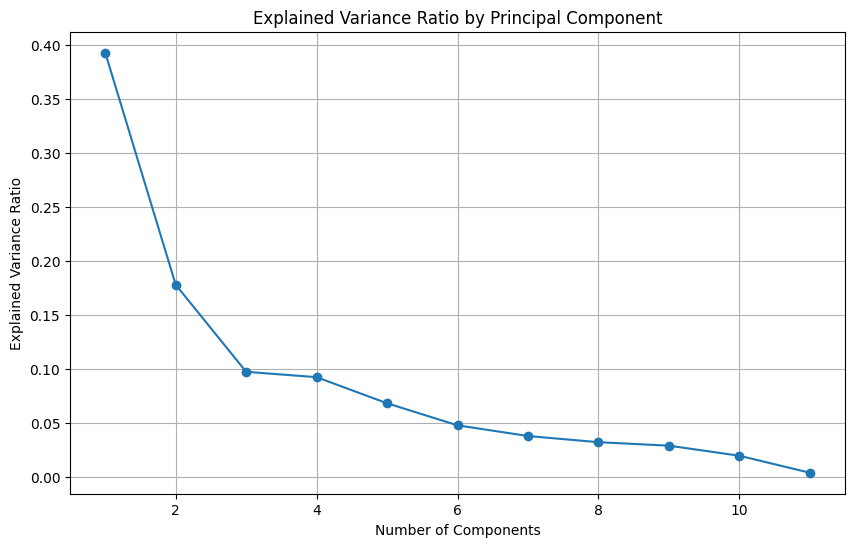

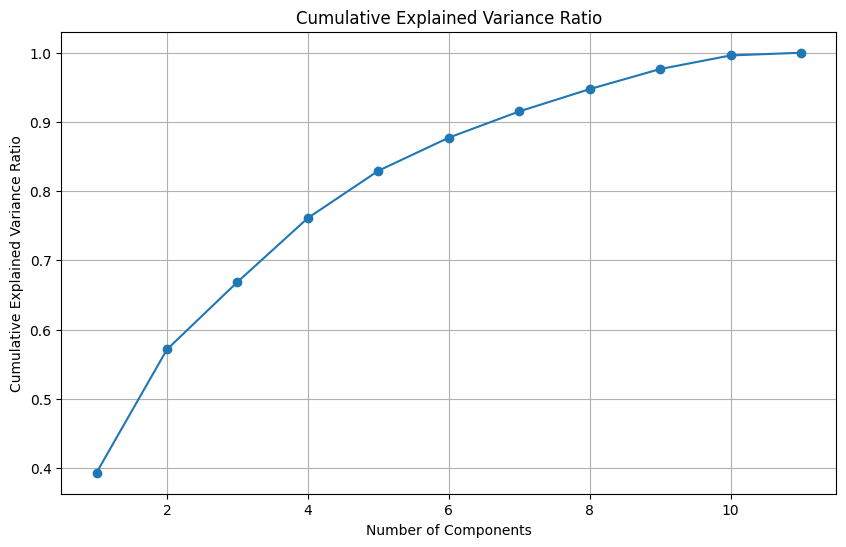

Number of components to retain for 95% variance: 9


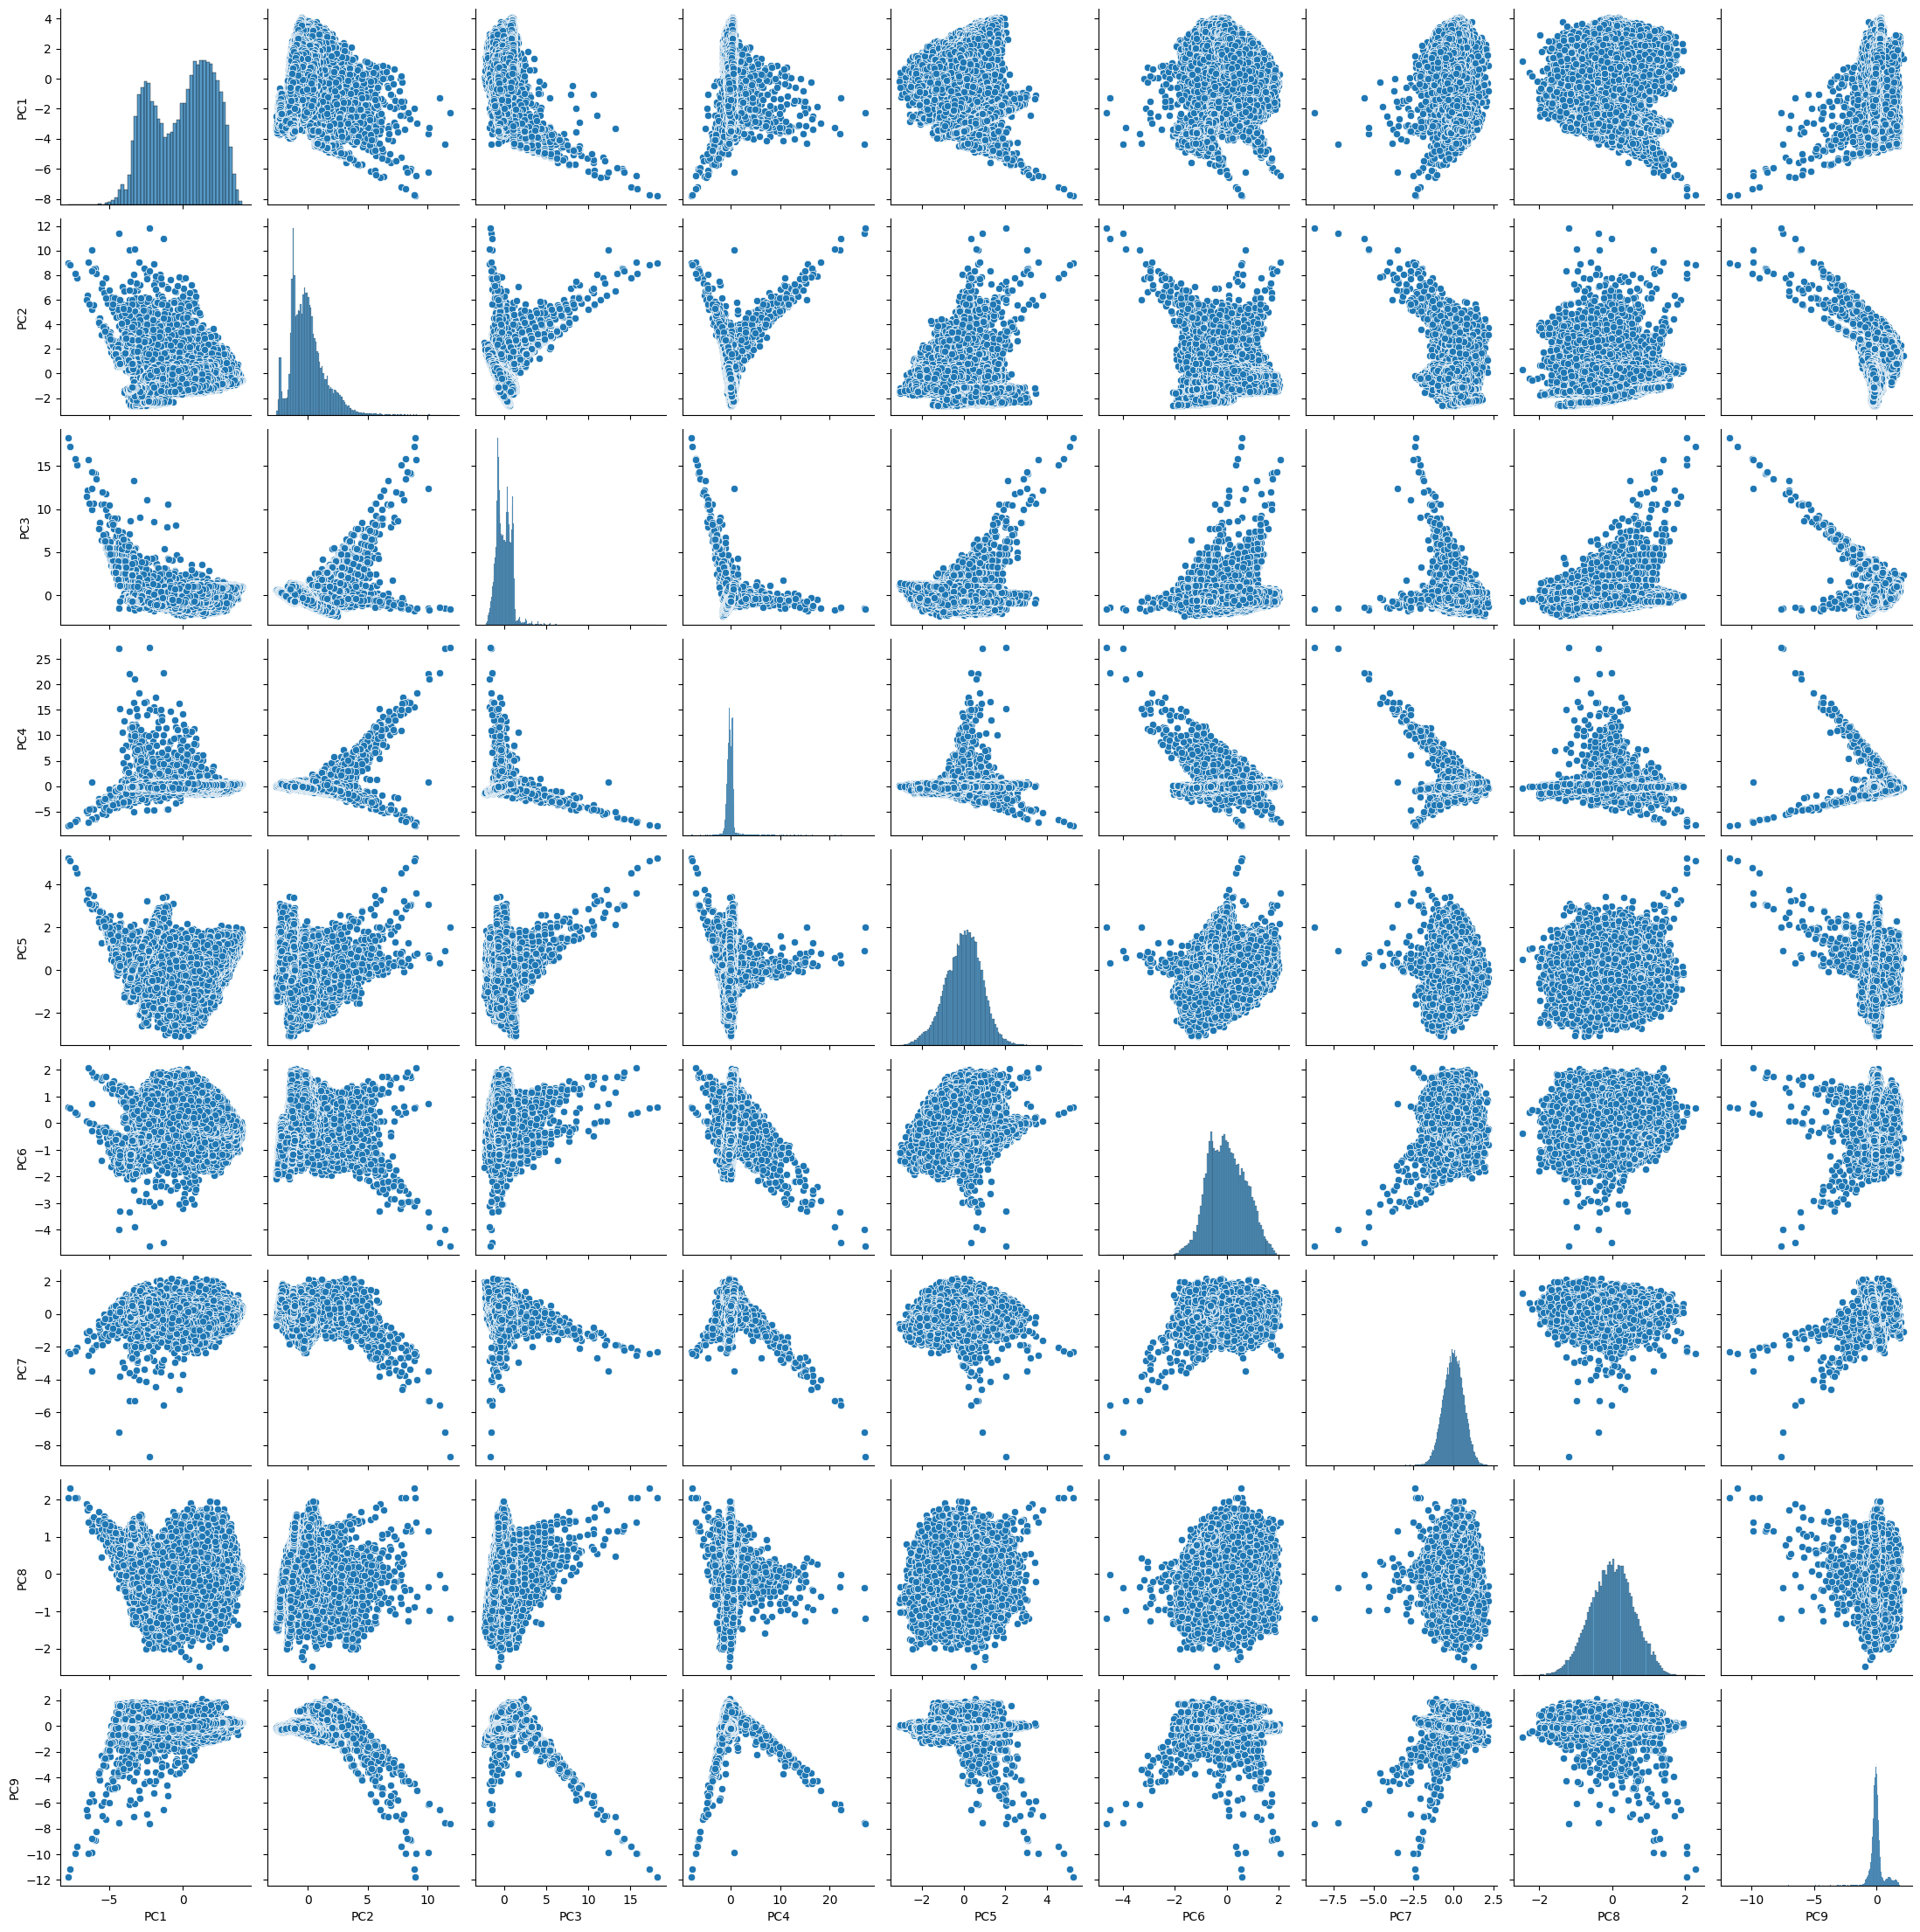

In [23]:
# prompt: Perform PCA on the data, and give me any interesting insights or things I should know

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'features' DataFrame is already defined as in the previous code

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_features)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.grid(True)
plt.show()


# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# Determine the number of components to retain (e.g., 95% variance)
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components to retain for 95% variance: {n_components}")

# Apply PCA with the selected number of components
pca_selected = PCA(n_components=n_components)
pca_result_selected = pca_selected.fit_transform(scaled_features)


#Further analysis can be done on pca_result_selected
# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result_selected, columns=[f'PC{i+1}' for i in range(n_components)])

#Explore relationships between principal components
sns.pairplot(pca_df)
plt.show()

#Insights and things to know:
# 1. Explained Variance Ratio plot: Helps to understand how much variance each principal component explains.
# 2. Scree plot (cumulative variance): Shows the cumulative variance explained by the components. Look for an "elbow" in the plot to determine the number of principal components that capture most of the variance.
# 3. Number of components: Based on the scree plot, decide how many principal components to retain for further analysis. A common rule of thumb is to select components that explain 95% or more of the total variance.
# 4. Feature importance: Examine the loadings of each principal component to see which original features contribute most to each component. This can provide insights into the underlying structure of the data.



                      PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8  \
temperature         0.657  0.153 -0.083  0.169  0.554  0.352  0.236  0.149   
humidity           -0.737  0.112  0.041  0.153 -0.425  0.092  0.394  0.262   
rain               -0.115  0.437 -0.051  0.848  0.026 -0.125 -0.170 -0.017   
snowfall           -0.316  0.453  0.689 -0.315  0.151  0.036 -0.081  0.035   
weather_code_daily -0.396  0.733  0.338  0.083  0.070 -0.044  0.063 -0.073   
cloud_cover        -0.386  0.587 -0.493 -0.290  0.043  0.000 -0.258  0.330   
is_day              0.629  0.428 -0.009 -0.009 -0.392  0.457 -0.098 -0.155   
sunshine_duration   0.879  0.003  0.117  0.022 -0.204  0.044 -0.136  0.148   
GHI                 0.876  0.233  0.054 -0.049  0.040 -0.306  0.139  0.098   
DHI                 0.502  0.629 -0.340 -0.220 -0.087 -0.215  0.225 -0.211   
DNI                 0.862 -0.115  0.309  0.071 -0.172 -0.156 -0.045  0.220   

                      PC9  
temperature        -0.016  
humidit

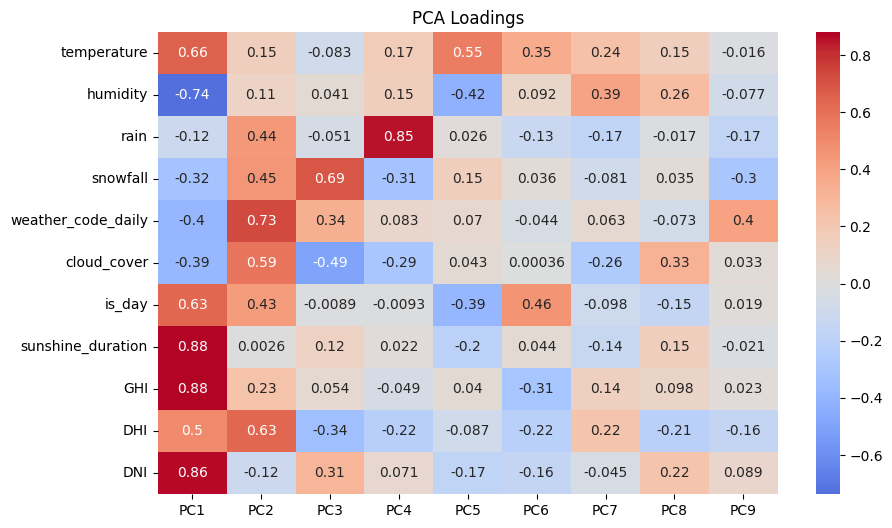

In [22]:
# prompt: I don't understand what the above plots mean. I only know what my features are but I don't understand how they connect with PCA. Can you give me an interpretation of what the above plots are and what are the insights?

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming 'pca_df' DataFrame from the previous code is available

# 1. Explained Variance Ratio Plot Interpretation:
# The first plot shows the variance explained by each principal component (PC).  Each PC is a new, uncorrelated variable created from a linear combination of the original features.  The plot shows how much information each PC retains from the original dataset.  For example, if PC1 explains 40% of the variance, it means that a single dimension (PC1) captures 40% of the information from all your original features (kWh, temperature, humidity, etc.). Subsequent PCs capture less and less variance.

# 2. Cumulative Explained Variance Ratio Plot Interpretation (Scree Plot):
# The second plot shows the cumulative variance explained. It adds up the variance explained by each successive principal component. This helps you see the point of diminishing returns – how many components do you need to retain most of the important information? The "elbow" or point where the curve flattens indicates a good number of components to keep.  In your code, you chose the number of components that explain at least 95% of the variance.  This means you've reduced the dimensionality of your data while retaining 95% of its information content.  This helps reduce noise, computational complexity, and potentially improves model performance.

# 3. Pairplot Interpretation:
# The `sns.pairplot(pca_df)` creates a matrix of scatterplots showing the relationship between each pair of principal components.  Look for patterns:
# * **Linear Relationships:** Strong positive or negative correlations suggest that two PCs are highly related, meaning they carry similar information.  This could point to redundant information and a potential opportunity to reduce the number of components further.
# * **Non-linear Relationships:**  Curved patterns or clusters may indicate more complex interactions within the data that were not apparent in the original features.
# * **No Relationships:**  Random scatter indicates that the PCs are independent of each other, as expected from PCA.  These uncorrelated components are beneficial for modeling as they represent distinct aspects of the data.

# Insights Example:
# Let's say PC1 is heavily influenced by 'kWh' and 'GHI' (global horizontal irradiance). PC2 is primarily driven by 'temperature' and 'humidity'.  This would mean that changes in solar irradiance and energy production are strongly linked (as reflected in PC1), and changes in temperature and humidity are captured in PC2. If you observe a strong positive correlation between PC1 and PC2 in the pairplot, it might suggest that higher solar irradiance and energy production are correlated with specific temperature and humidity conditions.  Conversely, if the correlation is weak or nonexistent, they are independent.


# Code to add to your existing script to further analyze feature importance:

# Feature importance based on the selected principal components:
loadings = pca_selected.components_.T * np.sqrt(pca_selected.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(n_components)], index=features.columns)
print(loading_matrix)

#Visualize loadings:
plt.figure(figsize=(10, 6))
sns.heatmap(loading_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loadings')
plt.show()

# Interpretation of Loading Matrix:
#The values in the loading matrix show how much each original feature contributes to each principal component. High positive or negative values indicate strong influence. For example, if 'GHI' has a high positive loading in PC1, this reinforces the observation that 'GHI' and 'kWh' are strongly associated (example above).

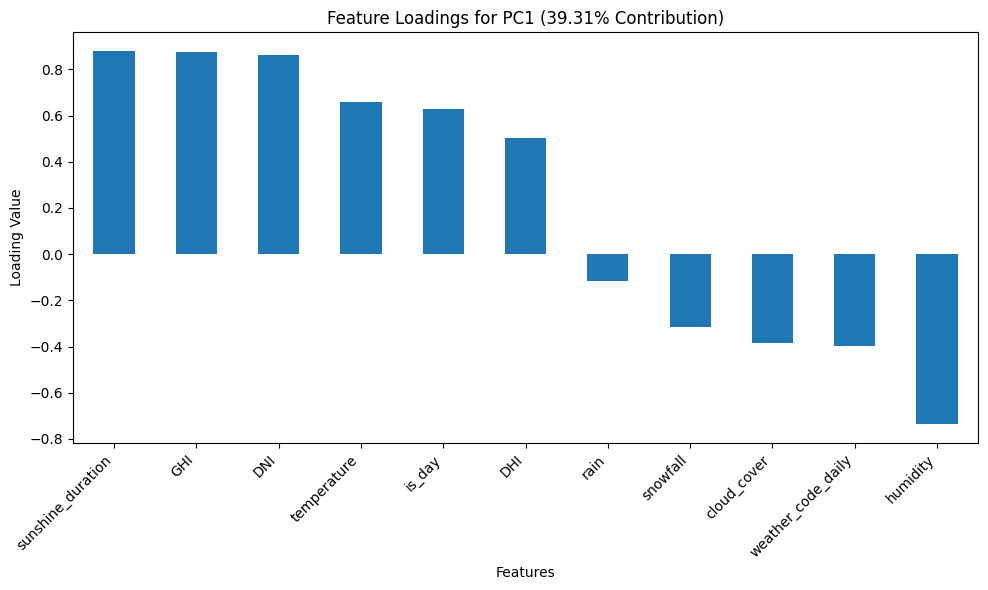

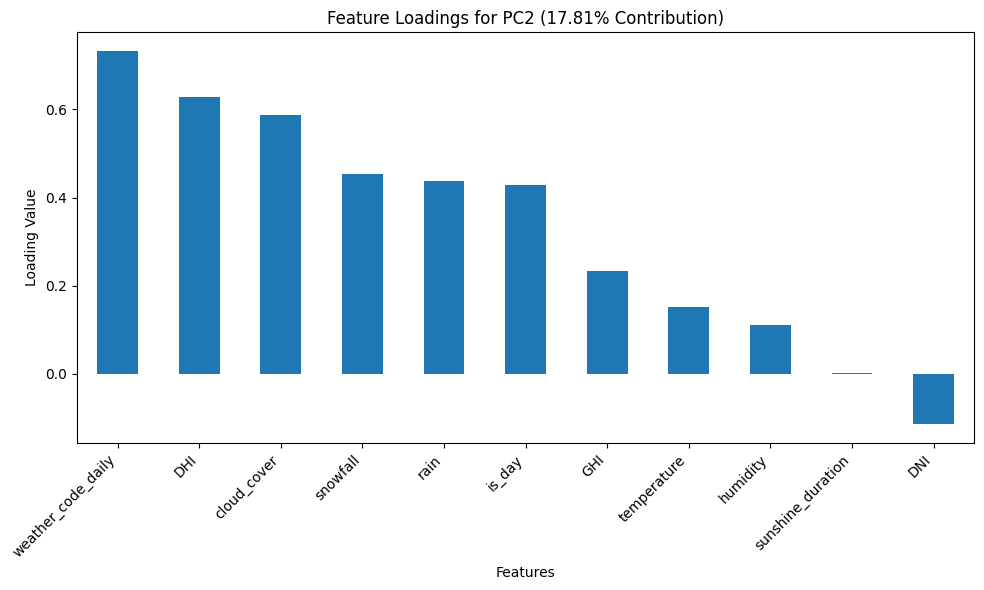

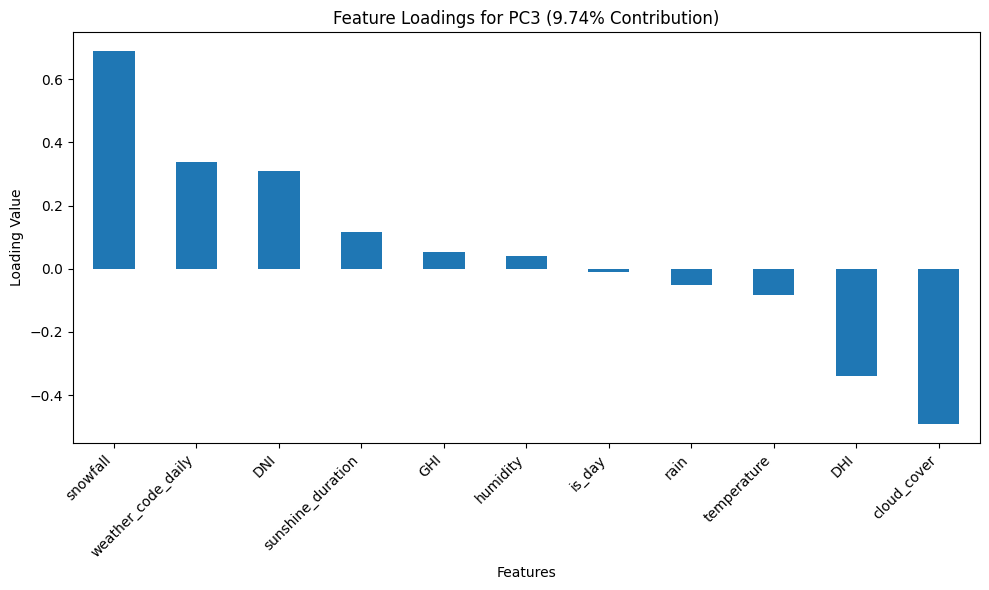

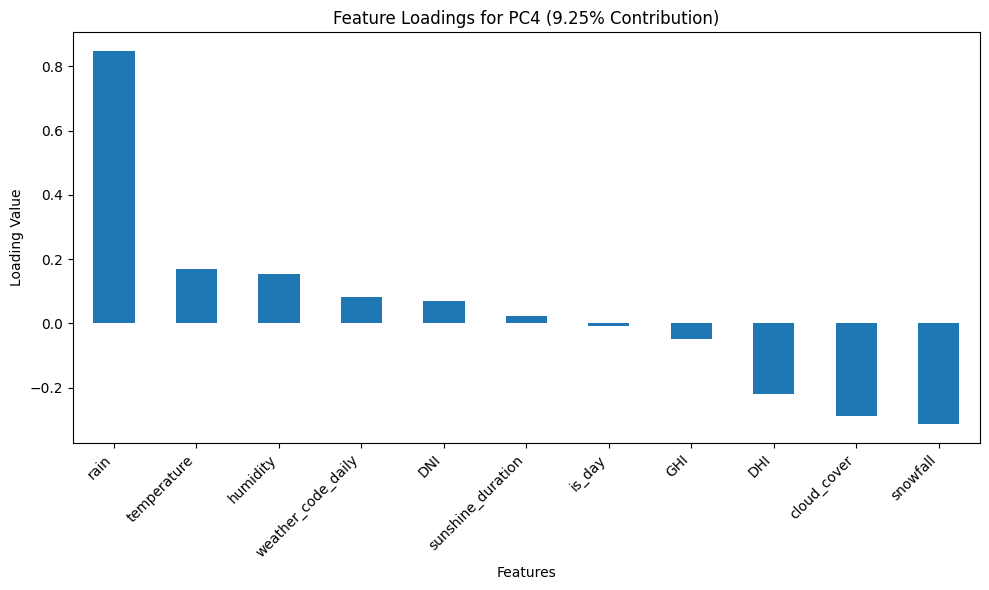

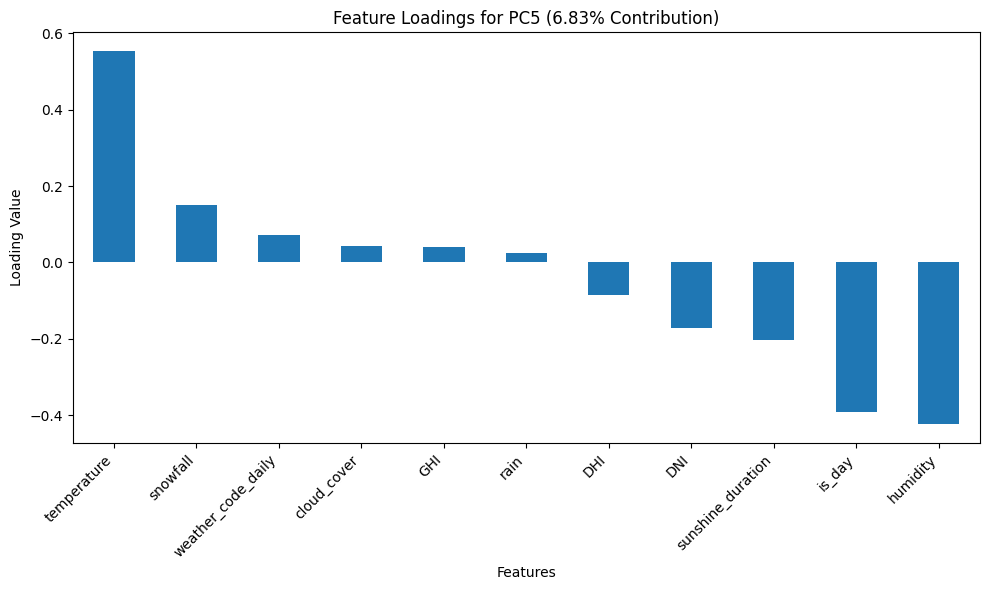

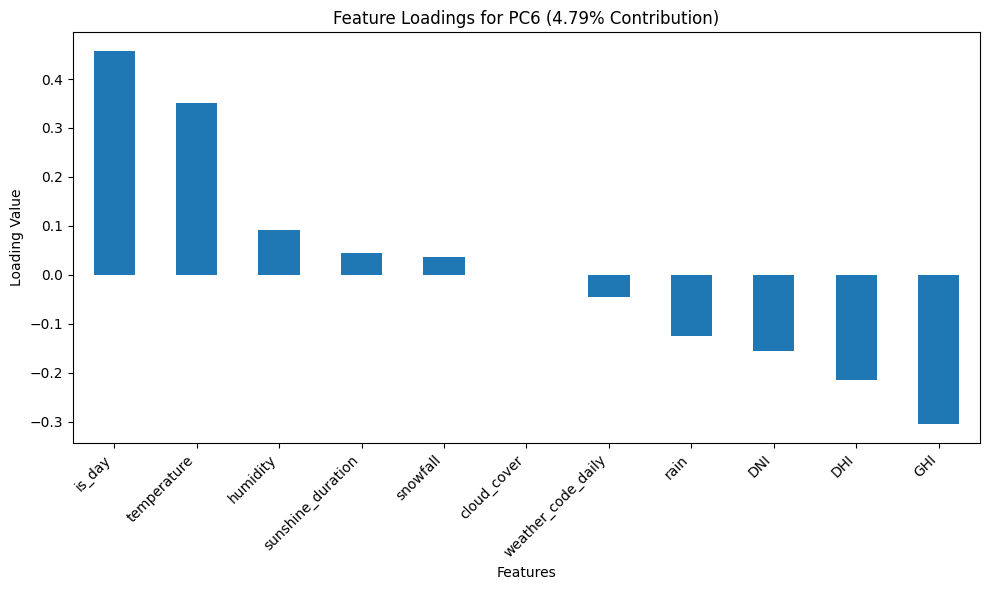

In [10]:
# prompt: Can you do a bar plot of the first 4 PCs for their feature loadings and also print their percentage of contribution of the PC to the data beside the title

import matplotlib.pyplot as plt

# Assuming 'loading_matrix' and 'explained_variance_ratio' are defined from previous code

# Bar plot of the first 4 PCs' feature loadings
for i in range(min(6, len(loading_matrix.columns))):  # Ensure we don't exceed the number of PCs
    pc_number = i + 1
    variance_percentage = explained_variance_ratio[i] * 100
    plt.figure(figsize=(10, 6))
    loading_matrix[f'PC{pc_number}'].sort_values(ascending=False).plot(kind='bar')
    plt.title(f'Feature Loadings for PC{pc_number} ({variance_percentage:.2f}% Contribution)')
    plt.xlabel('Features')
    plt.ylabel('Loading Value')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [24]:
pca_df.index = features.index

pca_df['hour'] = pca_df.index.hour
pca_df['month'] = pca_df.index.month

pca_df.describe()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
count 34356.000 34356.000 34356.000 34356.000 34356.000 34356.000 34356.000   
mean     -0.000    -0.000     0.000     0.000    -0.000     0.000    -0.000   
std       2.079     1.400     1.035     1.009     0.867     0.726     0.646   
min      -7.786    -2.628    -2.410    -7.837    -3.095    -4.613    -8.682   
25%      -1.908    -1.027    -0.710    -0.411    -0.564    -0.552    -0.432   
50%       0.349    -0.196    -0.087    -0.064     0.041    -0.037     0.011   
75%       1.733     0.688     0.609     0.341     0.591     0.530     0.443   
max       4.063    11.861    18.276    27.179     5.239     2.070     2.171   

            PC8       PC9      hour     month  
count 34356.000 34356.000 34356.000 34356.000  
mean      0.000    -0.000    13.500     6.535  
std       0.595     0.565     4.031     3.402  
min      -2.473   -11.742     7.000     1.000  
25%      -0.406    -0.217    10.000     4.000  
50%       0.010    -0.045    13.500     7.000  
75%       0.409     0.134    17.000     9.000  
max       2.299     2.154    20.000    12.000

In [30]:
scaler = MinMaxScaler()
pca_result_selected = scaler.fit_transform(pca_df)
pd.DataFrame(pca_result_selected).describe()

0         1         2         3         4         5         6   \
count 34356.000 34356.000 34356.000 34356.000 34356.000 34356.000 34356.000   
mean      0.657     0.181     0.116     0.224     0.371     0.690     0.800   
std       0.175     0.097     0.050     0.029     0.104     0.109     0.060   
min       0.000     0.000     0.000     0.000     0.000     0.000     0.000   
25%       0.496     0.111     0.082     0.212     0.304     0.608     0.760   
50%       0.687     0.168     0.112     0.222     0.376     0.685     0.801   
75%       0.803     0.229     0.146     0.234     0.442     0.770     0.841   
max       1.000     1.000     1.000     1.000     1.000     1.000     1.000   

             7         8         9         10  
count 34356.000 34356.000 34356.000 34356.000  
mean      0.518     0.845     0.500     0.503  
std       0.125     0.041     0.310     0.309  
min       0.000     0.000     0.000     0.000  
25%       0.433     0.829     0.231     0.273  
50%       0.520     0.842     0.500     0.545  
75%       0.604     0.855     0.769     0.727  
max       1.000     1.000     1.000     1.000

In [41]:
def make_train_test_split():
  days = 365
  hours = 14
  test_size = days * hours

  X_train = pca_result_selected[:-test_size]
  X_test = pca_result_selected[-test_size:]
  y_train = target.iloc[:-test_size].values.reshape(-1)
  y_test = target.iloc[-test_size:].values.reshape(-1)

  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = make_train_test_split()

(29246, 11) (5110, 11) (29246,) (5110,)


In [32]:
# Train a RandomForestRegressor model
rf_model = RandomForestRegressor(verbose=1) # You can tune hyperparameters
gb_model = GradientBoostingRegressor(verbose=1, n_estimators=400) # You can tune hyperparameters

rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
rmse_gb = root_mean_squared_error(y_test, y_pred_gb)

print(f"Root Mean Squared Error - Random Forest: {rmse_rf}")
print(f"Root Mean Squared Error - Gradient Boosting: {rmse_gb}")

# Feature Importance from the RandomForest model
feature_importances_rf = rf_model.feature_importances_
for i, importance in enumerate(feature_importances_rf):
    print(f"PC{i+1} - RF: {importance}")

# Feature Importance from the RandomForest model
feature_importances_gb = gb_model.feature_importances_
for i, importance in enumerate(feature_importances_gb):
    print(f"PC{i+1} - GB: {importance}")

# # Visualize feature importance from the random forest
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(feature_importances)), feature_importances)
# plt.xticks(range(len(feature_importances)), [f"PC{i+1}" for i in range(len(feature_importances))])
# plt.xlabel('Principal Component')
# plt.ylabel('Feature Importance')
# plt.title('Feature Importance from RandomForest')
# plt.show()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   19.7s


      Iter       Train Loss   Remaining Time 
         1       15761.4153           55.67s
         2       14098.6633           52.30s
         3       12723.8382           51.18s
         4       11601.3425           50.52s
         5       10664.9158           50.24s
         6        9900.1960           49.86s
         7        9263.6928           49.59s
         8        8741.8679           49.37s
         9        8292.0834           49.26s
        10        7929.4127           49.28s
        20        6325.6051           47.90s
        30        5930.8052           46.41s
        40        5760.8633           45.09s
        50        5662.6305           43.85s
        60        5598.0588           42.72s
        70        5550.6075           42.07s
        80        5503.0048           42.42s
        90        5470.2539           42.36s
       100        5428.2785           40.92s
       200        5167.5921           27.36s
       300        4962.8607           13.66s
       40

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Root Mean Squared Error - Random Forest: 55.83582542701903
Root Mean Squared Error - Gradient Boosting: 54.217929536414125
PC1 - RF: 0.5785477144900929
PC2 - RF: 0.06013862697873338
PC3 - RF: 0.027887551951328124
PC4 - RF: 0.027022146450448755
PC5 - RF: 0.038422510354684455
PC6 - RF: 0.11386486078180694
PC7 - RF: 0.03330392754994722
PC8 - RF: 0.039818405959121235
PC9 - RF: 0.030090983396857077
PC10 - RF: 0.03149009529318626
PC11 - RF: 0.01941317679379353
PC1 - GB: 0.7525111031072732
PC2 - GB: 0.040870638220738824
PC3 - GB: 0.017258924705305836
PC4 - GB: 0.0049043438621549475
PC5 - GB: 0.010584769843192987
PC6 - GB: 0.10886034998481874
PC7 - GB: 0.005757861699981517
PC8 - GB: 0.007999322440988338
PC9 - GB: 0.004351092237822539
PC10 - GB: 0.03285278882607259
PC11 - GB: 0.014048805071650548


In [33]:
# prompt: produce a plotly graph to view the actual vs predicted values for both Random Forest and Gradient Boosting and show them in a single graph, also can you use the dates from test_size days to the last day?

import plotly.graph_objects as go

# Assuming y_test, y_pred_rf, y_pred_gb, and data are already defined

# Extract dates for the test set
test_dates = data.index[-test_size:]

# Create the Plotly figure
fig = go.Figure()

# Add Random Forest predictions
fig.add_trace(go.Scatter(x=test_dates, y=y_test, mode='lines+markers', name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=test_dates, y=y_pred_rf, mode='lines+markers', name='Random Forest Predicted', line=dict(color='green')))

# Add Gradient Boosting predictions
fig.add_trace(go.Scatter(x=test_dates, y=y_pred_gb, mode='lines+markers', name='Gradient Boosting Predicted', line=dict(color='red')))


# Customize the layout
fig.update_layout(title='Actual vs. Predicted Values (Random Forest & Gradient Boosting)',
                  xaxis_title='Date',
                  yaxis_title='kWh',
                  legend=dict(x=0, y=1, traceorder='normal'))

fig.show()

In [34]:
# prompt: If you analyse the above result's it can be seen that they don't look that great. Both gradient boosting and random forest regressor didn't get the predictions rightly. Can you do some hyperparameter optimization for the both of them? Also, can you use XGBoost instead of Gradient Boosting and can you also add L1 and L2 regularization for XGBoost? Also, can you suggest the best LSTM architecture for my data and based on the patterns you found

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

tscv = TimeSeriesSplit(n_splits=10)

# XGBoost with L1 and L2 regularization
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=1)

# Hyperparameter grid for XGBoost
param_dist_xgb = {
    'n_estimators': [100, 200, 250, 300, 350, 400, 500],
    'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'subsample': [0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1, 10, 20],  # L1 regularization
    'reg_lambda': [0, 0.1, 1, 10, 20, 30, 40]   # L2 regularization
}

# RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=30,  # Number of parameter settings that are sampled
    scoring='neg_root_mean_squared_error',  # Use appropriate scoring metric
    cv=tscv,  # Number of cross-validation folds
    verbose=1,
    n_jobs=-1  # Use all available cores
)

random_search_xgb.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for XGBoost:", random_search_xgb.best_params_)
print("Best RMSE for XGBoost:", -random_search_xgb.best_score_) #Negative RMSE, so negated for display

# Use the best model for predictions
y_pred_xgb = random_search_xgb.best_estimator_.predict(X_test)

# Evaluate XGBoost model
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
print(f"Root Mean Squared Error - XGBoost: {rmse_xgb}")


# # Hyperparameter Optimization for RandomForestRegressor
# param_dist_rf = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [None, 10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }

# random_search_rf = RandomizedSearchCV(
#     estimator=RandomForestRegressor(random_state=42),
#     param_distributions=param_dist_rf,
#     n_iter=20,
#     scoring='neg_root_mean_squared_error',
#     cv=tscv,
#     verbose=1,
#     n_jobs=-1
# )

# random_search_rf.fit(X_train, y_train)

# print("Best parameters for RandomForest:", random_search_rf.best_params_)
# print("Best RMSE for RandomForest:", -random_search_rf.best_score_)

# y_pred_rf_optimized = random_search_rf.best_estimator_.predict(X_test)
# rmse_rf_optimized = root_mean_squared_error(y_test, y_pred_rf_optimized)
# print(f"Root Mean Squared Error - Optimized Random Forest: {rmse_rf_optimized}")


# # LSTM Model (example architecture – you can adjust)
# import tensorflow as tf
# from tensorflow import keras
# from keras.callbacks import EarlyStopping

# model = keras.Sequential([
#     keras.layers.LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),  # Adjust units as needed
#     keras.layers.Dropout(0.2),
#     keras.layers.LSTM(50, activation='relu'),
#     keras.layers.Dropout(0.2),
#     keras.layers.Dense(1)  # Output layer
# ])


# model.compile(optimizer='adam', loss='mse') #You might want to try different optimizers here.

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# history = model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train,
#                     validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1)

# y_pred_lstm = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
# rmse_lstm = root_mean_squared_error(y_test, y_pred_lstm)
# print(f"Root Mean Squared Error - LSTM: {rmse_lstm}")

# #Plot the loss for training and validation sets
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.show()

# #Further Improvements to LSTM
# #1. Experiment with different LSTM architectures
# #2. Experiment with GRU or Bidirectional LSTM
# #3. Feature Engineering/Selection - Add more features to the dataset to improve model prediction accuracy.
# #4. Consider using more advanced optimizers like RMSprop or AdamW with different learning rate schedules.

# #Visualization
# import plotly.graph_objects as go

# # ... (rest of your visualization code)
# fig.add_trace(go.Scatter(x=test_dates, y=y_pred_xgb, mode='lines+markers', name='XGBoost Predicted', line=dict(color='purple')))
# fig.add_trace(go.Scatter(x=test_dates, y=y_pred_lstm, mode='lines+markers', name='LSTM Predicted', line=dict(color='orange')))
# fig.show()

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters for XGBoost: {'subsample': 1.0, 'reg_lambda': 20, 'reg_alpha': 10, 'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Best RMSE for XGBoost: 75.32439980802693
Root Mean Squared Error - XGBoost: 56.36868373509339


In [35]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=1, n_estimators=350, learning_rate=0.01, reg_alpha=0.1, reg_lambda=10)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred_xgb)

print(f"Root Mean Squared Error - XGBoost: {rmse}")

Root Mean Squared Error - XGBoost: 53.49856008381611


In [36]:
# prompt: Create a plotly plot to view the results of y_pred of the above xgb model with the true values. I also want an analysis of the best predicted days (a day divided in a set of 14 hours between 7AM to 8PM in the above data) and also the worst predicted days. I'm interested in which PC was high and which PC was low that day.

import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Assuming y_test, y_pred_xgb, and test_dates are already defined

# Create a DataFrame for easier analysis
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test, 'Predicted': y_pred_xgb})

# Calculate the absolute error
results_df['Absolute_Error'] = np.abs(results_df['Actual'] - results_df['Predicted'])

# Group by day (assuming your data has hourly entries)
daily_results = results_df.groupby(results_df['Date'].dt.date).agg({'Absolute_Error': 'mean', 'Predicted':'mean', 'Actual': 'mean'})

# Sort by absolute error to find best and worst predicted days
daily_results = daily_results.sort_values(by='Absolute_Error')

# Best predicted days
best_days = daily_results.head(5)  # Top 5 best days

# Worst predicted days
worst_days = daily_results.tail(5) # Bottom 5 worst days


# Plotting
fig = go.Figure()

fig.add_trace(go.Scatter(x=results_df['Date'], y=results_df['Actual'], mode='lines+markers', name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=results_df['Date'], y=results_df['Predicted'], mode='lines+markers', name='XGBoost Predicted', line=dict(color='purple')))


# Highlight best and worst days
for date in best_days.index:
    date_str = str(date)
    fig.add_shape(
        type="rect",
        xref="x",
        yref="paper",
        x0=date_str,
        y0=0,
        x1=date_str,
        y1=1,
        line=dict(color="green", width=2),
    )
for date in worst_days.index:
    date_str = str(date)

    fig.add_shape(
        type="rect",
        xref="x",
        yref="paper",
        x0=date_str,
        y0=0,
        x1=date_str,
        y1=1,
        line=dict(color="red", width=2),
    )

fig.update_layout(title='Actual vs. Predicted Values (XGBoost) with Best/Worst Days',
                  xaxis_title='Date',
                  yaxis_title='kWh',
                  legend=dict(x=0, y=1, traceorder='normal'))

fig.show()

#Print the best and worst days with their corresponding PC values
print("Best Predicted Days:")
print(best_days)
print("\nWorst Predicted Days:")
worst_days

#To see which PC was high or low for those days, you can refer back to the pca_df DataFrame using the dates in best_days and worst_days indexes
#For example:
# for date in best_days.index:
#     print(f"\nPC values for {date}:")
#     print(pca_df.loc[str(date)])

Best Predicted Days:
            Absolute_Error  Predicted  Actual
Date                                         
2023-12-11           4.306     14.219  11.206
2024-12-04           4.687     13.199  11.685
2023-12-14           5.439     12.147   7.783
2023-12-08           6.548      6.641   0.093
2024-08-28           6.799     17.876  13.868

Worst Predicted Days:


Absolute_Error  Predicted  Actual
Date                                         
2024-04-02          89.323    152.610  72.650
2024-03-26          90.337     98.151 185.658
2024-02-21          93.225     90.643 180.746
2024-02-15         113.508     42.240 151.403
2024-03-25         137.678     58.813 194.509

In [37]:
results_df

Date  Actual  Predicted  Absolute_Error
0    2023-12-08 07:00:00   0.000      8.237           8.237
1    2023-12-08 08:00:00   0.000      5.835           5.835
2    2023-12-08 09:00:00   0.000      5.510           5.510
3    2023-12-08 10:00:00   0.000      6.134           6.134
4    2023-12-08 11:00:00   0.000     10.397          10.397
...                  ...     ...        ...             ...
5105 2024-12-10 16:00:00   1.890      9.357           7.467
5106 2024-12-10 17:00:00   0.000      2.682           2.682
5107 2024-12-10 18:00:00   0.000      2.608           2.608
5108 2024-12-10 19:00:00   0.000      3.441           3.441
5109 2024-12-10 20:00:00   0.000      3.441           3.441

[5110 rows x 4 columns]

In [70]:
# prompt: Transform the above X and y data to timesteps for training an LSTM model
X_train, X_test, y_train, y_test = make_train_test_split()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - 1):
        v = X.iloc[i:(i + time_steps + 1)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 14  # Example: Use the past 24 hours

X_train, y_train = create_dataset(pd.DataFrame(X_train), pd.DataFrame(y_train), TIME_STEPS)
X_test, y_test = create_dataset(pd.DataFrame(X_test), pd.DataFrame(y_test), TIME_STEPS)

X_val, y_val = X_train[-5100:], y_train[-5100:]
X_train, y_train = X_train[:-5100], y_train[:-5100]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(29246, 11) (5110, 11) (29246,) (5110,)
X_train shape: (29246, 11)
y_train shape: (29246,)
X_test shape: (5110, 11)
y_test shape: (5110,)
(24131, 15, 11) (24131, 1) (5095, 15, 11) (5095, 1) (5100, 15, 11) (5100, 1)


In [69]:
(5100/14) /30

12.142857142857142

In [71]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

model = Sequential()
model.add(Input(shape=(X_train.shape[1:])))
model.add(Bidirectional(LSTM(900, activation='relu', kernel_regularizer=l1(0.01), recurrent_regularizer=l2(0.01), return_sequences=True)))
model.add(Dropout(0.3))
# Pass the regularizers to the LSTM layer
model.add(LSTM(300, activation='relu', kernel_regularizer=l1(0.01), recurrent_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(250, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae', RootMeanSquaredError()])

model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1), ModelCheckpoint('best_model.keras', save_best_only=True, verbose=1)])

model = load_model('best_model.keras', custom_objects={'RootMeanSquaredError': RootMeanSquaredError})

y_pred_lstm = model.predict(X_test)
rmse_lstm = root_mean_squared_error(y_test, y_pred_lstm)
print(f"Root Mean Squared Error - LSTM: {rmse_lstm}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 15, 1800)            │       6,566,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 1800)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 300)                 │       2,521,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 250)                 │          75,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,163,101 (34.95 MB)

 Trainable params: 9,163,101 (34.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 17334.9199 - mae: 87.1023 - root_mean_squared_error: 128.2920
Epoch 1: val_loss improved from inf to 11812.67383, saving model to best_model.keras
378/378 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - loss: 17317.7363 - mae: 87.0522 - root_mean_squared_error: 128.2250 - val_loss: 11812.6738 - val_mae: 75.7256 - val_root_mean_squared_error: 107.7590
Epoch 2/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6545.8228 - mae: 52.6275 - root_mean_squared_error: 79.7059
Epoch 2: val_loss improved from 11812.67383 to 8742.99316, saving model to best_model.keras
378/378 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - loss: 6545.5229 - mae: 52.6248 - root_mean_squared_error: 79.7041 - val_loss: 8742.9932 - val_mae: 63.5888 - val_root_mean_squared_error: 92.5876
Epoch 3/50
377/378 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5585.7446 - mae: 47.5686 - root_mean_squared_error: 73.5951
Epoch 3: val_loss did not improve from 8742.99316
378/378 ━━━━━━━━━━━━━━

In [55]:
# pd.DataFrame({'Actual':y_test.reshape(-1), 'Pred': y_pred_lstm.reshape(-1)})
import plotly.graph_objects as go

test_size_lstm = len(X_test)
test_dates = target.index[-test_size_lstm:]

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test.reshape(-1), mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=test_dates, y=y_pred_lstm.reshape(-1), mode='lines', name='Predicted'))
fig.update_layout(title='Actual vs Predicted kWh', xaxis_title='Date', yaxis_title='kWh')
fig.show()

# Create a DataFrame for easier analysis
results_df_lstm = pd.DataFrame({'Date': test_dates, 'Actual': y_test.reshape(-1), 'Predicted': y_pred_lstm.reshape(-1)})

# Calculate the absolute error
results_df_lstm['Absolute_Error'] = np.abs(results_df_lstm['Actual'] - results_df_lstm['Predicted'])

# Group by day (assuming your data has hourly entries)
daily_results_lstm = results_df_lstm.groupby(results_df_lstm['Date'].dt.date).agg({'Absolute_Error': 'mean', 'Predicted':'mean', 'Actual': 'mean'})

# Sort by absolute error to find best and worst predicted days
daily_results_lstm = daily_results_lstm.sort_values(by='Absolute_Error')

# Best predicted days
best_days_lstm = daily_results_lstm.head(5)  # Top 5 best days

# Worst predicted days
worst_days_lstm = daily_results_lstm.tail(5) # Bottom 5 worst days

In [57]:
best_days_lstm, best_days

(            Absolute_Error  Predicted  Actual
 Date                                         
 2023-12-14           2.092      9.876   7.783
 2024-12-08           2.180     10.731  11.415
 2024-11-20           2.894      7.814   4.920
 2023-12-18           2.941     10.173   7.923
 2023-12-11           3.110     10.479  11.206,
             Absolute_Error  Predicted  Actual
 Date                                         
 2023-12-11           4.306     14.219  11.206
 2024-12-04           4.687     13.199  11.685
 2023-12-14           5.439     12.147   7.783
 2023-12-08           6.548      6.641   0.093
 2024-08-28           6.799     17.876  13.868)

In [58]:
worst_days_lstm, worst_days

(            Absolute_Error  Predicted  Actual
 Date                                         
 2024-03-04          87.300     89.938   2.639
 2024-04-02          89.122    154.893  72.632
 2024-02-15          99.484     59.373 151.403
 2024-03-06         115.049    138.217  23.168
 2024-03-25         117.674     78.585 194.509,
             Absolute_Error  Predicted  Actual
 Date                                         
 2024-04-02          89.323    152.610  72.650
 2024-03-26          90.337     98.151 185.658
 2024-02-21          93.225     90.643 180.746
 2024-02-15         113.508     42.240 151.403
 2024-03-25         137.678     58.813 194.509)

In [83]:
# prompt: Transform the above X and y data to timesteps for training an LSTM model
X_train, X_test, y_train, y_test = make_train_test_split()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

def create_dataset_day_ahead(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):  # Adjust for both previous and forecast hours
        # Collect features from the previous day (24 hours) and the current day (up to the current hour)
        X_cur = X[i - time_steps:i + 1].reshape(-1, X.shape[-1])  # Features from the previous day
        # The target is the next day's forecast (next 14 hours)
        y_target = y[i]

        Xs.append(X_cur)
        ys.append(y_target)

    # print(Xs[0].shape, ys[0].shape)

    return np.array(Xs), np.array(ys)

# Create the datasets
TIME_STEPS = 1  # Previous 14 hours data to predict next 14 hours
# FORECAST_HOURS = 14  # Predict the next 14 hours

X_train = X_train.reshape(-1, 14, X_train.shape[1])
X_test = X_test.reshape(-1, 14, X_test.shape[1])
y_train = y_train.reshape(-1, 14)
y_test = y_test.reshape(-1, 14)

X_train, y_train = create_dataset_day_ahead(X_train, y_train, TIME_STEPS)
X_test, y_test = create_dataset_day_ahead(X_test, y_test, TIME_STEPS)

X_val, y_val = X_train[-150:], y_train[-150:]
X_train, y_train = X_train[:-150], y_train[:-150]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)


(29246, 11) (5110, 11) (29246,) (5110,)
X_train shape: (29246, 11)
y_train shape: (29246,)
X_test shape: (5110, 11)
y_test shape: (5110,)
(1938, 28, 11) (1938, 14) (364, 28, 11) (364, 14) (150, 28, 11) (150, 14)


In [1]:
y_train[0, :]

NameError: name 'y_train' is not defined

In [78]:
data.iloc[0:len(data)]

kWh  temperature  humidity  rain  snowfall  \
2017-12-21 07:00:00 0.000       -9.800    64.000 0.000     0.000   
2017-12-21 08:00:00 0.000       -8.800    63.000 0.000     0.000   
2017-12-21 09:00:00 0.004       -6.100    59.000 0.000     0.000   
2017-12-21 10:00:00 0.433       -4.800    61.000 0.000     0.000   
2017-12-21 11:00:00 0.854       -4.500    69.000 0.000     0.000   
...                   ...          ...       ...   ...       ...   
2024-12-10 16:00:00 1.890       -4.900    84.000 0.000     0.000   
2024-12-10 17:00:00 0.000       -6.700    88.000 0.000     0.000   
2024-12-10 18:00:00 0.000       -4.800    91.000 0.000     0.000   
2024-12-10 19:00:00 0.000       -4.800    94.000 0.000     0.000   
2024-12-10 20:00:00 0.000       -5.300    96.000 0.000     0.000   

                     weather_code_daily  cloud_cover  is_day  \
2017-12-21 07:00:00               2.000       51.000       0   
2017-12-21 08:00:00               3.000       86.000       0   
2017-12-21 09:00:00               3.000       90.000       1   
2017-12-21 10:00:00               3.000       96.000       1   
2017-12-21 11:00:00               3.000      100.000       1   
...                                 ...          ...     ...   
2024-12-10 16:00:00               3.000       84.000       1   
2024-12-10 17:00:00               3.000      100.000       0   
2024-12-10 18:00:00               3.000      100.000       0   
2024-12-10 19:00:00               3.000      100.000       0   
2024-12-10 20:00:00               3.000      100.000       0   

                     sunshine_duration     GHI     DHI     DNI  
2017-12-21 07:00:00              0.000   0.000   0.000   0.000  
2017-12-21 08:00:00              0.000   0.000   0.000   0.000  
2017-12-21 09:00:00              0.000   7.200   7.200   0.000  
2017-12-21 10:00:00            826.160  81.100  63.600 133.500  
2017-12-21 11:00:00           2315.170 137.900 107.900 164.400  
...                                ...     ...     ...     ...  
2024-12-10 16:00:00           2848.110  32.900  18.500 112.300  
2024-12-10 17:00:00              0.000   0.000   0.000   0.000  
2024-12-10 18:00:00              0.000   0.000   0.000   0.000  
2024-12-10 19:00:00              0.000   0.000   0.000   0.000  
2024-12-10 20:00:00              0.000   0.000   0.000   0.000  

[34356 rows x 12 columns]

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

model_day_ahead = Sequential()
model_day_ahead.add(Input(shape=(X_train.shape[1:])))
model_day_ahead.add(Bidirectional(LSTM(900, activation='relu', kernel_regularizer=l1(0.01), recurrent_regularizer=l2(0.01), return_sequences=True)))
model_day_ahead.add(Dropout(0.3))
# Pass the regularizers to the LSTM layer
model_day_ahead.add(LSTM(300, activation='relu', kernel_regularizer=l1(0.01), recurrent_regularizer=l2(0.01)))
model_day_ahead.add(Dropout(0.2))
model_day_ahead.add(Dense(250, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model_day_ahead.add(Dense(y_train.shape[1], activation='linear'))

# Compile the model_day_ahead
model_day_ahead.compile(optimizer='adam', loss='mse', metrics=['mae', RootMeanSquaredError()])

model_day_ahead.summary()

# Train the model_day_ahead
model_day_ahead.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), ModelCheckpoint('best_model_day_ahead.keras', save_best_only=True)])

model_day_ahead = load_model('best_model_day_ahead.keras', custom_objects={'RootMeanSquaredError': RootMeanSquaredError})

y_pred_lstm = model_day_ahead.predict(X_test)



X_train shape: (29204, 14, 18)
y_train shape: (29204, 14, 1)
X_test shape: (5068, 14, 18)
y_test shape: (5068, 14, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 14, 1800)            │       6,616,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 1800)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 300)                 │       2,521,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 250)                 │          75,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           3,514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,216,764 (35.16 MB)

 Trainable params: 9,216,764 (35.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - loss: 23103.4395 - mae: 98.8374 - root_mean_squared_error: 148.9964 - val_loss: 5430.0054 - val_mae: 47.2231 - val_root_mean_squared_error: 70.9318
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 626s 3s/step - loss: 8275.8447 - mae: 61.1967 - root_mean_squared_error: 88.7963 - val_loss: 5337.7788 - val_mae: 46.6454 - val_root_mean_squared_error: 70.4809
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - loss: 7508.4341 - mae: 57.5129 - root_mean_squared_error: 84.5036 - val_loss: 5715.1309 - val_mae: 46.0172 - val_root_mean_squared_error: 73.2162
Epoch 4/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - loss: 6578.9497 - mae: 52.6682 - root_mean_squared_error: 78.9075 - val_loss: 6238.3120 - val_mae: 48.5464 - val_root_mean_squared_error: 76.7608
Epoch 5/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - loss: 6007.7339 - mae: 49.6957 - root_mean_squared_error: 75.2437 - val_loss: 5796.2124 - val_mae: 46.6363 - val_root_mean_squared_error: 7

In [ ]:
rmse_lstm = root_mean_squared_error(y_test.reshape(-1), y_pred_lstm.reshape(-1))
print(f"Root Mean Squared Error - LSTM: {rmse_lstm}")
# y_test.shape, y_pred_lstm.shape

Root Mean Squared Error - LSTM: 71.16671629022726


In [ ]:
# prompt: Print RMSE, and also produce a plotly graph to view the actual vs predicted values

import plotly.graph_objects as go

dates = target.index[-test_size:]

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dates, y=y_pred_xgb, mode='lines', name='Predicted'))
fig.update_layout(title='Actual vs Predicted kWh', xaxis_title='Date', yaxis_title='kWh')
fig.show()

In [ ]:
# prompt: Give me a graph to see the weather conditions on the best prediction days and the weather conditions on the worst days. Also, I want to see which factors influenced the most for the worst predictions and the best predictions

import plotly.graph_objects as go
import pandas as pd

# Assuming y_test and y_pred are already defined from your previous code
# Create a DataFrame for easier manipulation
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results_df['Difference'] = abs(results_df['Actual'] - results_df['Predicted'])

# Find the indices of the best and worst prediction days
best_days_indices = results_df['Difference'].nsmallest(10).index  # Top 10 best predictions
worst_days_indices = results_df['Difference'].nlargest(10).index  # Top 10 worst predictions

# Assuming 'data' DataFrame and feature columns from your previous code
best_days_weather = data.loc[best_days_indices, ['temperature', 'humidity', 'rain', 'snowfall', 'GHI', 'kWh']]
worst_days_weather = data.loc[worst_days_indices, ['temperature', 'humidity', 'rain', 'snowfall', 'GHI', 'kWh']]


# Create the plot
fig = go.Figure()

# Add traces for best days
fig.add_trace(go.Scatter(x=best_days_weather.index, y=best_days_weather['kWh'],
                         mode='markers+lines', name='Actual kWh (Best)', marker=dict(color='green')))
fig.add_trace(go.Scatter(x=best_days_weather.index, y=results_df.loc[best_days_indices, 'Predicted'],
                         mode='markers+lines', name='Predicted kWh (Best)', marker=dict(color='lightgreen')))

# Add traces for worst days
fig.add_trace(go.Scatter(x=worst_days_weather.index, y=worst_days_weather['kWh'],
                         mode='markers+lines', name='Actual kWh (Worst)', marker=dict(color='red')))

fig.add_trace(go.Scatter(x=worst_days_weather.index, y=results_df.loc[worst_days_indices, 'Predicted'],
                         mode='markers+lines', name='Predicted kWh (Worst)', marker=dict(color='lightcoral')))

fig.update_layout(title='Actual vs Predicted kWh (Best & Worst Days)',
                  xaxis_title='Date',
                  yaxis_title='kWh',
                  yaxis_range=[0, max(results_df['Actual'])*1.1])  #Adjust y-axis range
fig.show()

# Analyze factors influencing best and worst predictions:
print("Weather conditions and factors for the best prediction days:")
print(best_days_weather)

print("\nWeather conditions and factors for the worst prediction days:")
worst_days_weather

# Further analysis using feature importances from your RandomForest model (already printed in your original code):
# Compare the feature importances across best and worst predictions to pinpoint influential factors.
# Example: If PC1 (primarily influenced by GHI) has a high importance, then GHI might be a key factor for the deviations.


Weather conditions and factors for the best prediction days:
                     temperature  humidity  rain  snowfall  GHI  kWh
2024-11-19 18:00:00         -7.5      95.0   0.0      0.00  0.0  0.0
2024-01-06 19:00:00         -5.6      79.0   0.0      0.49  0.0  0.0
2024-01-10 20:00:00        -22.7      69.0   0.0      0.07  0.0  0.0
2024-11-19 08:00:00         -5.9      92.0   0.0      0.00  0.0  0.0
2024-02-27 19:00:00        -19.3      76.0   0.0      0.00  0.0  0.0
2024-12-02 19:00:00          0.5      63.0   0.0      0.00  0.0  0.0
2023-12-15 17:00:00         -3.1      79.0   0.0      0.00  0.0  0.0
2024-02-04 18:00:00         -6.6      90.0   0.0      0.07  0.0  0.0
2024-01-16 18:00:00         -9.1      83.0   0.0      0.07  0.0  0.0
2024-01-11 20:00:00        -30.4      62.0   0.0      0.00  0.0  0.0

Weather conditions and factors for the worst prediction days:


temperature  humidity  rain  snowfall    GHI      kWh
2024-03-25 14:00:00         -7.3      83.0   0.0       0.0  524.8  398.053
2024-03-25 11:00:00        -10.2      80.0   0.0       0.0  509.7  328.734
2024-02-15 14:00:00         -7.9      62.0   0.0       0.0  282.4  367.719
2024-06-20 14:00:00         18.4      34.0   0.0       0.0  825.6   86.659
2024-06-15 15:00:00         14.0      55.0   0.0       0.0  706.1   10.411
2024-02-15 13:00:00         -8.2      66.0   0.0       0.0  408.5  410.400
2024-02-15 11:00:00        -11.1      74.0   0.0       0.0  368.9  353.218
2024-02-15 12:00:00         -9.2      71.0   0.0       0.0  457.0  422.924
2024-06-02 12:00:00         16.6      44.0   0.1       0.0  795.5   98.484
2024-02-29 10:00:00          5.5      63.0   0.0       0.0  248.5  347.267

In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_norm = scaler_X.fit_transform(features)
y_norm = scaler_y.fit_transform(target)

X_norm.shape, y_norm.shape

((22204, 20), (22204, 1))

In [ ]:
# def get_nearest_date(target_date, available_dates):
#     """
#     Finds the nearest available date for a given target date.
#     """
#     nearest_date = min(available_dates, key=lambda x: abs(x - target_date))
#     return nearest_date
#
# features_dates = pd.to_datetime(features.index.date)
# complete_dates = pd.date_range(features_dates.min(), features_dates.max(), freq='D')
# missing_dates = complete_dates.difference(features_dates)
#
# features_dates = features_dates.unique()
#
# missing_date_to_nearest = {
#     missing_date: get_nearest_date(missing_date, features_dates) for missing_date in missing_dates
# }
#
# missing_date_to_nearest

In [ ]:
tscv = TimeSeriesSplit(n_splits=150, test_size=28)
model = RandomForestRegressor()
val_list = []

for train_index, test_index in tscv.split(X_norm):
    X_train, X_test = X_norm[train_index], X_norm[test_index]
    y_train, y_test = y_norm[train_index].reshape(-1), y_norm[test_index].reshape(-1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test).reshape(-1, 1)
    y_pred_scaled = scaler_y.inverse_transform(y_pred).reshape(-1)
    y_test_scaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
    dates = features.index[test_index]

    val_list.append([dates, y_test_scaled, y_pred_scaled])

    # combined_values = pd.DataFrame({'date': dates, 'true': y_test_scaled, 'predicted': y_pred_scaled})
    # fig = px.line(combined_values, x='date', y=combined_values.columns, markers=True)
    # fig.update_layout(title=f"Dates {dates[0]} to {dates[-1]}")

    # fig.show()

    print(f"Dates {dates[0]} to {dates[-1]}")

KeyboardInterrupt: 

In [ ]:
tscv = TimeSeriesSplit(n_splits=150, test_size=28)
model = RandomForestRegressor()
val_list = []

for train_index, test_index in tscv.split(X_norm):
    X_train, X_test = X_norm[train_index], X_norm[test_index]
    y_train, y_test = y_norm[train_index].reshape(-1), y_norm[test_index].reshape(-1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test).reshape(-1, 1)
    y_pred_scaled = scaler_y.inverse_transform(y_pred).reshape(-1)
    y_test_scaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
    dates = features.index[test_index]

    val_list.append([dates, y_test_scaled, y_pred_scaled])

    # combined_values = pd.DataFrame({'date': dates, 'true': y_test_scaled, 'predicted': y_pred_scaled})
    # fig = px.line(combined_values, x='date', y=combined_values.columns, markers=True)
    # fig.update_layout(title=f"Dates {dates[0]} to {dates[-1]}")

    # fig.show()

    print(f"Dates {dates[0]} to {dates[-1]}")

Dates 2022-03-18 07:00:00 to 2022-03-19 20:00:00
Dates 2022-03-20 07:00:00 to 2022-03-21 20:00:00
Dates 2022-03-22 07:00:00 to 2022-03-23 20:00:00
Dates 2022-03-24 07:00:00 to 2022-03-25 20:00:00
Dates 2022-03-26 07:00:00 to 2022-03-27 20:00:00
Dates 2022-03-28 07:00:00 to 2022-03-29 20:00:00
Dates 2022-03-30 07:00:00 to 2022-03-31 20:00:00
Dates 2022-04-01 07:00:00 to 2022-04-02 20:00:00
Dates 2022-04-03 07:00:00 to 2022-04-04 20:00:00
Dates 2022-04-05 07:00:00 to 2022-04-06 20:00:00
Dates 2022-04-07 07:00:00 to 2022-04-08 20:00:00
Dates 2022-04-09 07:00:00 to 2022-04-10 20:00:00
Dates 2022-04-11 07:00:00 to 2022-04-12 20:00:00
Dates 2022-04-13 07:00:00 to 2022-04-14 20:00:00
Dates 2022-04-15 07:00:00 to 2022-04-16 20:00:00
Dates 2022-04-17 07:00:00 to 2022-04-18 20:00:00
Dates 2022-04-19 07:00:00 to 2022-04-20 20:00:00
Dates 2022-04-21 07:00:00 to 2022-04-22 20:00:00
Dates 2022-04-23 07:00:00 to 2022-04-24 20:00:00
Dates 2022-04-25 07:00:00 to 2022-04-26 20:00:00
Dates 2022-04-27 07:

In [ ]:
# pd.DataFrame(, columns=['dates', 'true', 'predicted'])
np.hstack(np.array(val_list)[0])

array([1647586800000000000, 1647590400000000000, 1647594000000000000,
       1647597600000000000, 1647601200000000000, 1647604800000000000,
       1647608400000000000, 1647612000000000000, 1647615600000000000,
       1647619200000000000, 1647622800000000000, 1647626400000000000,
       1647630000000000000, 1647633600000000000, 1647673200000000000,
       1647676800000000000, 1647680400000000000, 1647684000000000000,
       1647687600000000000, 1647691200000000000, 1647694800000000000,
       1647698400000000000, 1647702000000000000, 1647705600000000000,
       1647709200000000000, 1647712800000000000, 1647716400000000000,
       1647720000000000000, 0.242999999999995, 71.049, 184.244, 224.974,
       186.153, 315.666, 324.46, 285.038, 381.921, 199.502, 151.956,
       64.128, 8.924999999999997, 0.0, 0.21600000000000819,
       22.138999999999996, 152.578, 294.258, 363.683, 407.107, 337.21,
       466.921, 368.883, 262.336, 212.026, 103.802, 9.0, 0.0,
       4.096299999999957, 72.281140

In [ ]:
# prompt: I have 28 rows of dates, 28 rows of y_true and 28 rows of y_pred in one row of val_list. I want to convert the whole list into a dataframe such that each row of the dataframe is [date, y_true, y_pred] for one hour of one day

import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Assuming val_list is already defined as in your provided code

all_data = []
for dates, y_true, y_pred in val_list:
    for i in range(len(dates)):
        all_data.append([dates[i], y_true[i], y_pred[i]])

df = pd.DataFrame(all_data, columns=['date', 'y_true', 'y_pred'])
df

date  y_true  y_pred
0    2022-03-18 07:00:00   0.243   4.096
1    2022-03-18 08:00:00  71.049  72.281
2    2022-03-18 09:00:00 184.244 182.432
3    2022-03-18 10:00:00 224.974 240.838
4    2022-03-18 11:00:00 186.153 300.142
...                  ...     ...     ...
4195 2023-03-15 16:00:00 133.972 103.705
4196 2023-03-15 17:00:00  32.062  35.839
4197 2023-03-15 18:00:00  16.458  45.988
4198 2023-03-15 19:00:00   1.868  19.466
4199 2023-03-15 20:00:00   0.000   0.000

[4200 rows x 3 columns]

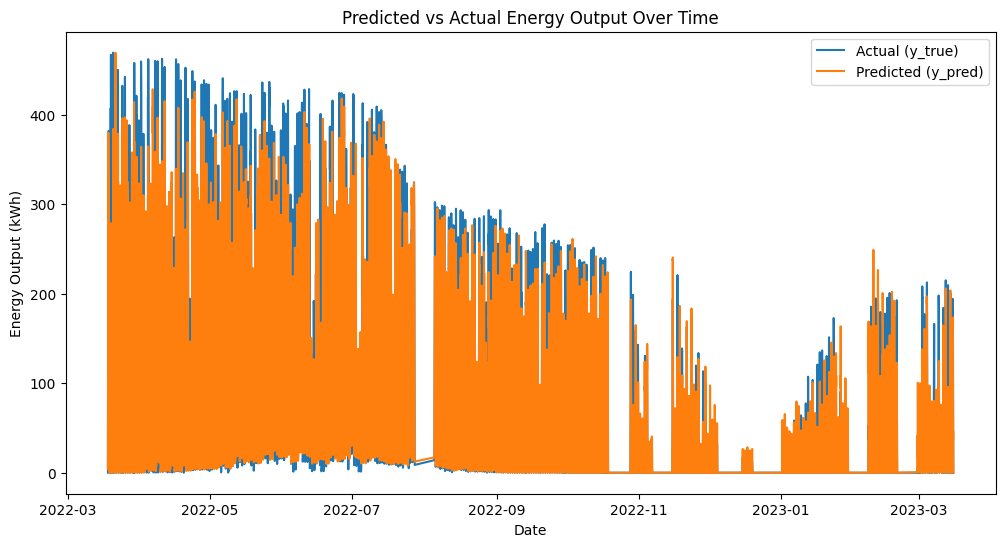

In [ ]:
# @title Predicted vs Actual Energy Output Over Time

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['y_true'], label='Actual (y_true)')
plt.plot(df['date'], df['y_pred'], label='Predicted (y_pred)')
plt.xlabel('Date')
plt.ylabel('Energy Output (kWh)')
plt.title('Predicted vs Actual Energy Output Over Time')
_ = plt.legend()
#plt.show()

In [ ]:
# prompt: Convert the above code to plotly express line plot

import plotly.express as px

fig = px.line(df, x='date', y=['y_true', 'y_pred'], markers=True)
fig.update_layout(title='Predicted vs Actual Energy Output Over Time',
                  xaxis_title='Date',
                  yaxis_title='Energy Output (kWh)')
fig.show()

kWh_24_hour_lag - 49.78%
kWh_72_hour_lag - 9.55%
cloud_cat - 6.22%
humidity_cat - 6.19%
kWh_48_hour_lag - 4.54%
kWh_120_hour_lag - 4.36%
kWh_144_hour_lag - 4.11%
kWh_168_hour_lag - 3.87%
kWh_96_hour_lag - 3.76%
day_cos - 1.39%
day_sin - 1.26%
temperature_cat - 0.86%
month_cos - 0.82%
month_sin - 0.72%
hour_cos - 0.65%
hour_sin - 0.61%
rain - 0.46%
quarter_cos - 0.32%
snowfall - 0.28%
quarter_sin - 0.23%


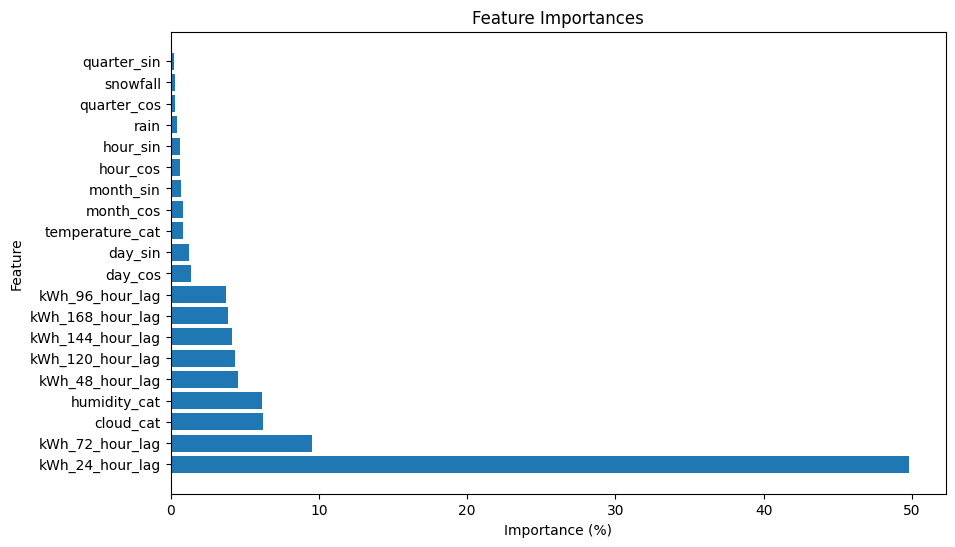

In [ ]:
# prompt: generate the feature importances for the model in the format feature - importance. I want it in descending order and I want it in percentage

import matplotlib.pyplot as plt
importances = model.feature_importances_
feature_names = features.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances['importance'] = feature_importances['importance'] * 100
for index, row in feature_importances.iterrows():
    print(f"{row['feature']} - {row['importance']:.2f}%")
plt.figure(figsize=(10,6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()